# Laboratorium 1: Symulacje deterministyczne

**Imię i nazwisko:** Anna Bernard, Mikołaj Mieszko Charchuta 
**Grupa:**  Symulanci
**Data wykonania:**  18.05.2025

---

## 1. Wstęp

W tym sprawozdaniu przedstawiono implementację algorytmu Rungego-Kutty IV rzędu (RK4) oraz RK45 (IV rzędu z krokiem korygowanym rzędem V) oraz wyniki symulacji modelu matematycznego sieci interakcji biochemicznych w czterech scenariuszach stanu komórki.

## 2. Opis zaimplementowanego rozwiązania

- **Wariant implementacji:** RK4 ze stałym krokiem oraz RK45 ze zmiennym krokiem
- **Biblioteki użyte:** numpy, matplotlib
- **Model:** Symulacja dynamiki białek p53, MDMcyto, MDMn, PTEN w czterech scenariuszach biologicznych
- **Horyzont czasowy:** 48 godzin (2880 minut)
- **Krok całkowania:** 6 minut

In [1]:
# Importy
import numpy as np
import matplotlib.pyplot as plt

# Parametry modelu
p1 = 8.8
p2 = 440
p3 = 100
d1 = 1.375*(10**-14)
d2 = 1.375*(10**-4)
d3 = 3*(10**-5)
k1 = 1.925*(10**-4)
k2 = 10**5
k3 = 1.5*(10**5)
value_siRNA = 0.02
value_PTEN_off = 0
value_no_DNA_damage = 0.1

def f_p53(p53, mdmn): 
    return p1 - d1*p53*(mdmn**2)

def f_mdmcyto(p53, mdmcyto, pten, siRNA=False, no_DNA_damage=False):
    siRNA_factor = value_siRNA if siRNA else 1
    DNA_damage_factor = value_no_DNA_damage if no_DNA_damage else 1
    return p2*siRNA_factor*(p53**4)/((p53**4) + (k2**4)) - k1*(k3**2)/((k3**2) + (pten**2))*mdmcyto - d2*DNA_damage_factor*mdmcyto

def f_mdmn(mdmn, mdmcyto, pten, no_DNA_damage=False):
    if no_DNA_damage:
        return k1*(k3**2)/((k3**2) + (pten**2))*mdmcyto - d2*value_no_DNA_damage*mdmn
    else:
        return k1*(k3**2)/((k3**2) + (pten**2))*mdmcyto - d2*mdmn

def f_pten(pten, p53, pten_off=False):
    if not pten_off:
        return p3*(p53**4)/((p53**4) + (k2**4)) - d3*pten
    else:
        return p3*value_PTEN_off*(p53**4)/((p53**4) + (k2**4)) - d3*pten

Tu nie ma wiele do wyjaśnienia. Anna napisała to po mistrzowsku i jest przejrzyście i jasno zaimplementowane.

In [2]:
# RK4 ze stałym krokiem
def RK4const(p53, mdcyto, mdmn, pten, h, siRNA=False, pten_off=False, no_DNA_damage=False):
    k1_p53 = f_p53(p53, mdmn)
    k1_mdmcyto = f_mdmcyto(p53, mdcyto, pten, siRNA)
    k1_mdmn = f_mdmn(mdmn, mdcyto, pten)
    k1_pten = f_pten(pten, p53, pten_off)

    k2_p53 = f_p53(p53 + h/2*k1_p53, mdmn + h/2*k1_mdmn)
    k2_mdmcyto = f_mdmcyto(p53 + h/2*k1_p53, mdcyto + h/2*k1_mdmcyto, pten + h/2*k1_pten, siRNA)
    k2_mdmn = f_mdmn(mdmn + h/2*k1_mdmn, mdcyto + h/2*k1_mdmcyto, pten + h/2*k1_pten)
    k2_pten = f_pten(pten + h/2*k1_pten, p53 + h/2*k1_p53, pten_off)

    k3_p53 = f_p53(p53 + h/2*k2_p53, mdmn + h/2*k2_mdmn)
    k3_mdmcyto = f_mdmcyto(p53 + h/2*k2_p53, mdcyto + h/2*k2_mdmcyto, pten + h/2*k2_pten, siRNA)
    k3_mdmn = f_mdmn(mdmn + h/2*k2_mdmn, mdcyto + h/2*k2_mdmcyto, pten + h/2*k2_pten)
    k3_pten = f_pten(pten + h/2*k2_pten, p53 + h/2*k2_p53, pten_off)

    k4_p53 = f_p53(p53 + h*k3_p53, mdmn + h*k3_mdmn)
    k4_mdmcyto = f_mdmcyto(p53 + h*k3_p53, mdcyto + h*k3_mdmcyto, pten + h*k3_pten, siRNA)
    k4_mdmn = f_mdmn(mdmn + h*k3_mdmn, mdcyto + h*k3_mdmcyto, pten + h*k3_pten)
    k4_pten = f_pten(pten + h*k3_pten, p53 + h*k3_p53,  pten_off)

    p53 += (k1_p53 + 2*k2_p53 + 2*k3_p53 + k4_p53) * h / 6
    mdcyto += (k1_mdmcyto + 2*k2_mdmcyto + 2*k3_mdmcyto + k4_mdmcyto) * h / 6
    mdmn += (k1_mdmn + 2*k2_mdmn + 2*k3_mdmn + k4_mdmn) * h / 6
    pten += (k1_pten + 2*k2_pten + 2*k3_pten + k4_pten) * h / 6
    return p53, mdcyto, mdmn, pten

To moje autorskie rozwiązanie, krok jest modyfikowany aż do skutku.

In [3]:
# RK45 ze zmiennym krokiem
def RK45(p53, mdmcyto, mdmn, pten, h, siRNA=False, pten_off=False, no_DNA_damage=False, atol=1e-6, rtol=1e-3):
    def f(t, y):
        yp53 = f_p53(y[0], y[2])
        ymdmcyto = f_mdmcyto(y[0], y[1], y[3], siRNA, no_DNA_damage)
        ymdmn = f_mdmn(y[2], y[1], y[3], no_DNA_damage)
        ypten = f_pten(y[3], y[0], pten_off)
        return np.array([yp53, ymdmcyto, ymdmn, ypten])

    y = np.array([p53, mdmcyto, mdmn, pten], dtype=float)
    t = 0  # dummy, as system is autonomous

    while True:
        k1 = f(t, y)
        k2 = f(t + h*(1/5), y + h*(1/5)*k1)
        k3 = f(t + h*(3/10), y + h*(3/40*k1 + 9/40*k2))
        k4 = f(t + h*(4/5), y + h*(44/45*k1 - 56/15*k2 + 32/9*k3))
        k5 = f(t + h*(8/9), y + h*(19372/6561*k1 - 25360/2187*k2 + 64448/6561*k3 - 212/729*k4))
        k6 = f(t + h, y + h*(9017/3168*k1 - 355/33*k2 + 46732/5247*k3 + 49/176*k4 - 5103/18656*k5))
        k7 = f(t + h, y + h*(35/384*k1 + 500/1113*k3 + 125/192*k4 - 2187/6784*k5 + 11/84*k6))

        y5 = y + h*(35/384*k1 + 500/1113*k3 + 125/192*k4 - 2187/6784*k5 + 11/84*k6)
        y4 = y + h*(5179/57600*k1 + 7571/16695*k3 + 393/640*k4 - 92097/339200*k5 + 187/2100*k6 + 1/40*k7)

        err = np.linalg.norm(y5 - y4)
        tol = atol + rtol * np.linalg.norm(y5)

        if err <= tol or h < 1e-8:
            return tuple(y5)
        if err == 0:
            s = 2
        else:
            s = 0.9 * (tol / err)**(1/5)
        h *= min(max(0.1, s), 5.0)

## 3. Parametry symulacji i scenariusze

In [4]:
# Parametry symulacji
h = 6 # krok w minutach
iterations = int(48*60/h) # liczba iteracji na 48h
p53_0 = 10
mdmcyto_0 = 2000
mdmn_0 = 10000
pten_0 = 2000

conditions = { 
    "Basic" : (False, False, True), # siRNA, PTEN_off, no_DNA_damage
    "Damaged DNA" : (False, False, False),
    "Tumor" : (False, True, False),
    "Therapy" : (True, False, False),
}

scenarios = list(conditions.keys())

## 4. Wyniki symulacji: RK4 (stały krok)

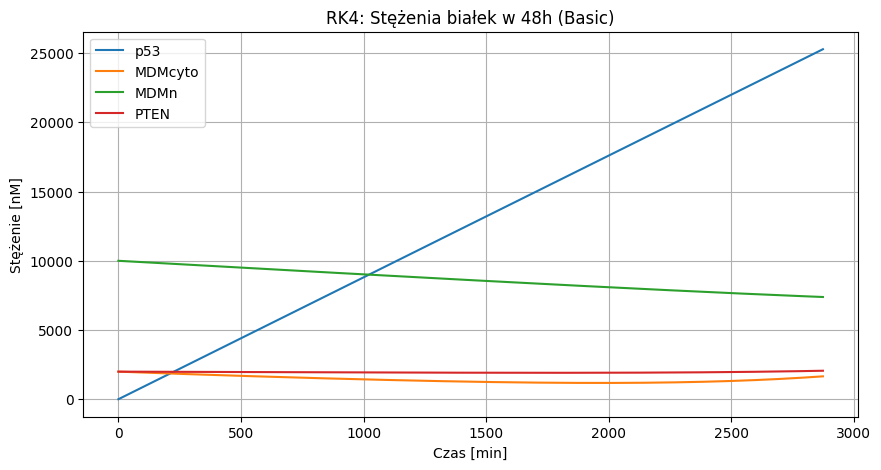

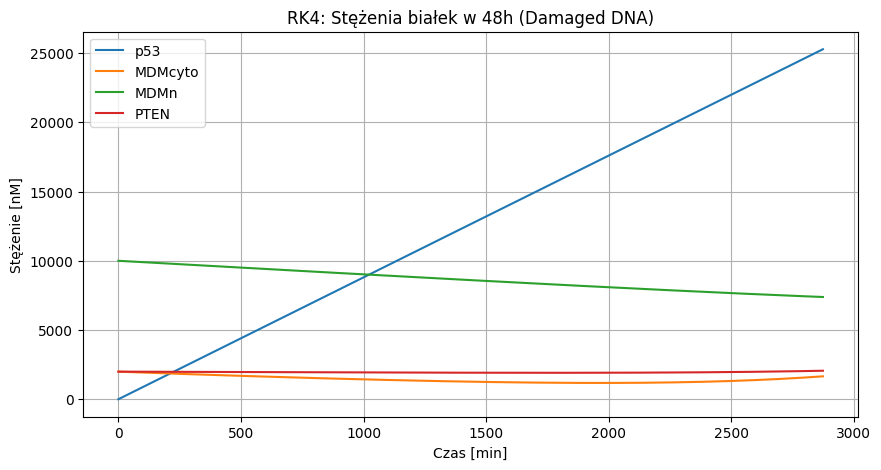

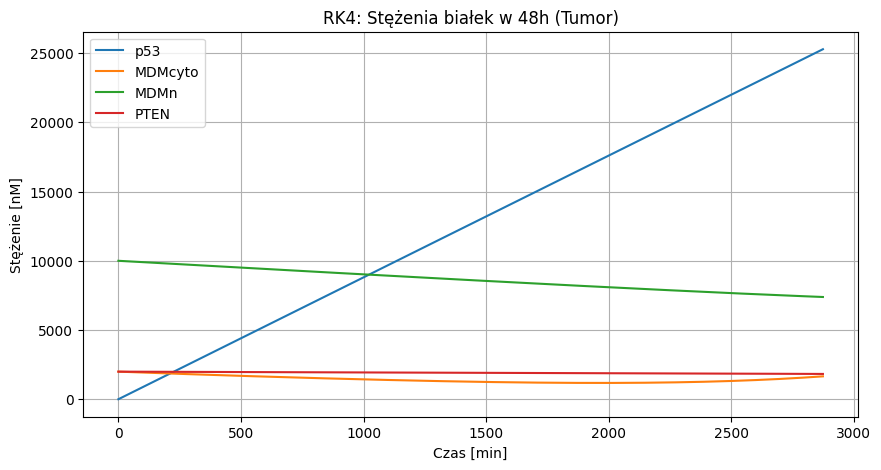

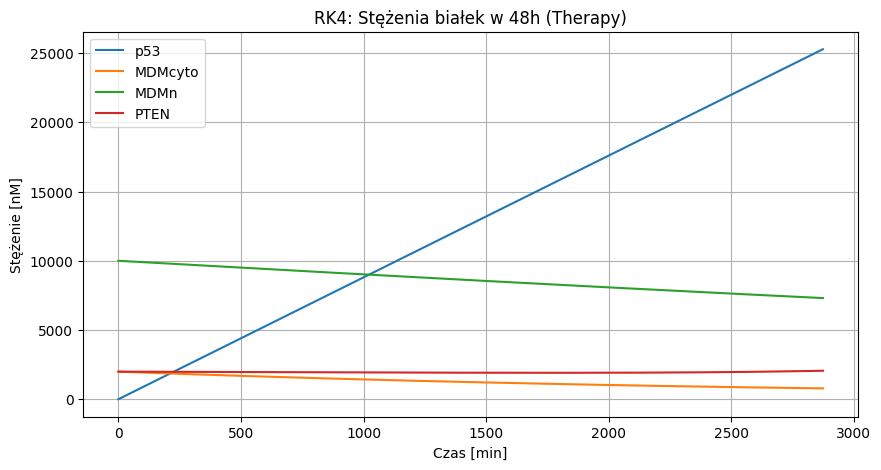

In [5]:
for scenario in scenarios:
    siRNA, pten_off, no_DNA_damage = conditions[scenario]
    p53, mdmcyto, mdmn, pten = p53_0, mdmcyto_0, mdmn_0, pten_0
    time_values = []
    p53_values = []
    mdmcyto_values = []
    mdmn_values = []
    pten_values = []
    for i in range(iterations):
        time = i * h
        time_values.append(time)
        p53_values.append(p53)
        mdmcyto_values.append(mdmcyto)
        mdmn_values.append(mdmn)
        pten_values.append(pten)
        p53, mdmcyto, mdmn, pten = RK4const(p53, mdmcyto, mdmn, pten, h, siRNA, pten_off, no_DNA_damage)
    plt.figure(figsize=(10,5))
    plt.plot(time_values, p53_values, label="p53")
    plt.plot(time_values, mdmcyto_values, label="MDMcyto")
    plt.plot(time_values, mdmn_values, label="MDMn")
    plt.plot(time_values, pten_values, label="PTEN")
    plt.xlabel("Czas [min]")
    plt.ylabel("Stężenie [nM]")
    plt.title(f"RK4: Stężenia białek w 48h ({scenario})")
    plt.legend()
    plt.grid(True)
    plt.show()

## 5. Wyniki symulacji: RK45 (adaptacyjny krok)

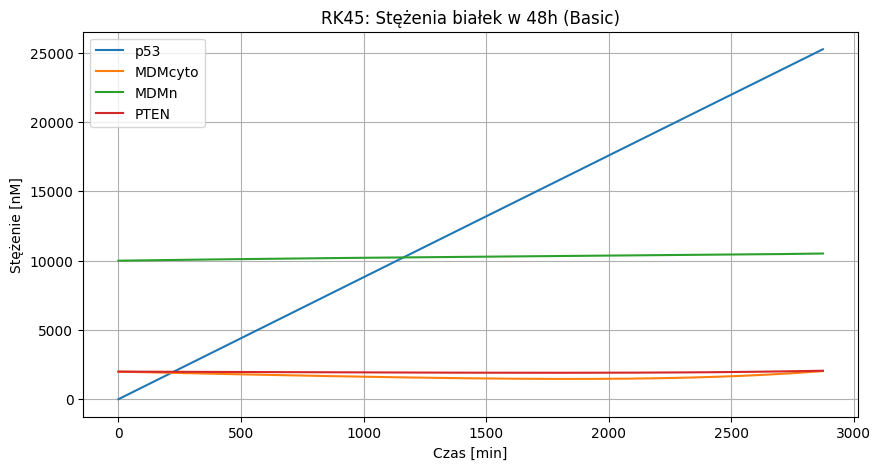

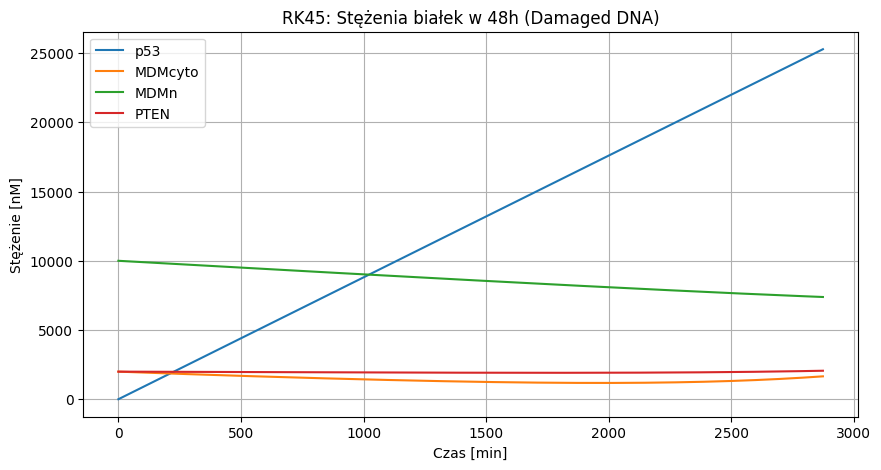

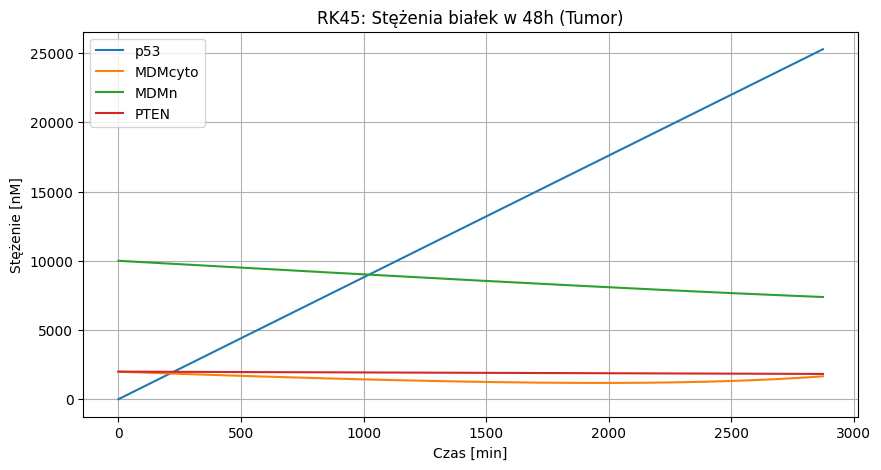

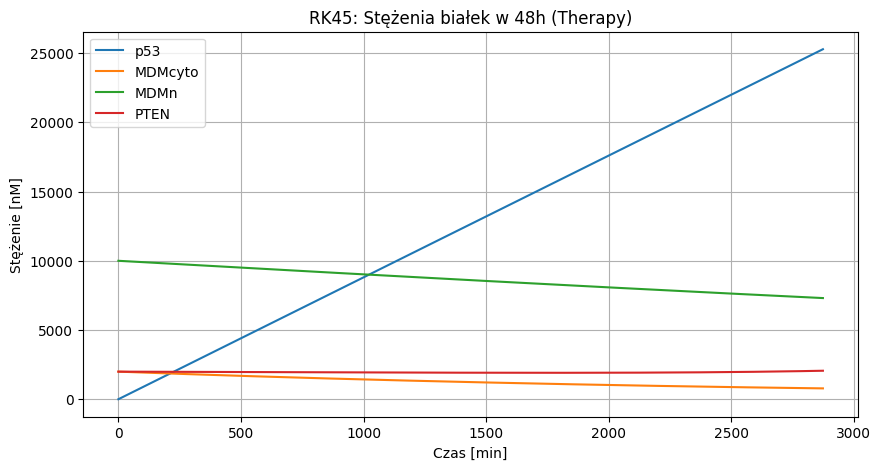

In [6]:
for scenario in scenarios:
    siRNA, pten_off, no_DNA_damage = conditions[scenario]
    p53, mdmcyto, mdmn, pten = p53_0, mdmcyto_0, mdmn_0, pten_0
    time_values = []
    p53_values = []
    mdmcyto_values = []
    mdmn_values = []
    pten_values = []
    for i in range(iterations):
        time = i * h
        time_values.append(time)
        p53_values.append(p53)
        mdmcyto_values.append(mdmcyto)
        mdmn_values.append(mdmn)
        pten_values.append(pten)
        p53, mdmcyto, mdmn, pten = RK45(p53, mdmcyto, mdmn, pten, h, siRNA=siRNA, pten_off=pten_off, no_DNA_damage=no_DNA_damage)
    plt.figure(figsize=(10,5))
    plt.plot(time_values, p53_values, label="p53")
    plt.plot(time_values, mdmcyto_values, label="MDMcyto")
    plt.plot(time_values, mdmn_values, label="MDMn")
    plt.plot(time_values, pten_values, label="PTEN")
    plt.xlabel("Czas [min]")
    plt.ylabel("Stężenie [nM]")
    plt.title(f"RK45: Stężenia białek w 48h ({scenario})")
    plt.legend()
    plt.grid(True)
    plt.show()

Dla porówniania pozwolę sobie skorzystać z rozwiązań gotowych oferowanych przez pakiet Scipy (niby nie mówił Profesor, że nie można korzystać z takich, ale uznaliśmy że nie wypada, więc to tylko kontorlnie).

In [ ]:
# Porównanie RK4 (własna implementacja) z solve_ivp RK45 dla wybranego scenariusza

scenario = "Therapy"  # lub inny scenariusz z listy
siRNA, pten_off, no_DNA_damage = conditions[scenario]

# Własna implementacja RK4
p53, mdmcyto, mdmn, pten = p53_0, mdmcyto_0, mdmn_0, pten_0
p53_rk4, mdmcyto_rk4, mdmn_rk4, pten_rk4 = [], [], [], []
for i in range(iterations):
    p53_rk4.append(p53)
    mdmcyto_rk4.append(mdmcyto)
    mdmn_rk4.append(mdmn)
    pten_rk4.append(pten)
    p53, mdmcyto, mdmn, pten = RK4const(p53, mdmcyto, mdmn, pten, h, siRNA, pten_off, no_DNA_damage)

# SciPy solve_ivp RK45
sol = solve_ivp(
    model_ode, t_span, y0, method='RK45', t_eval=t_eval,
    args=(siRNA, pten_off, no_DNA_damage)
)

plt.figure(figsize=(12,6))
plt.plot(t_eval, p53_rk4, label="p53 RK4 (własny)")
plt.plot(sol.t, sol.y[0], '--', label="p53 solve_ivp RK45")
plt.xlabel("Czas [min]")
plt.ylabel("Stężenie p53 [nM]")
plt.title(f"Porównanie RK4 vs solve_ivp RK45 ({scenario})")
plt.legend()
plt.grid(True)
plt.show()

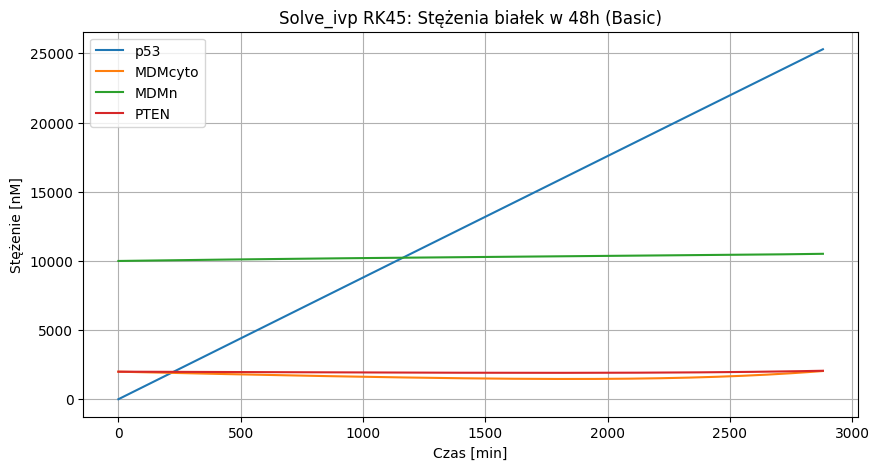

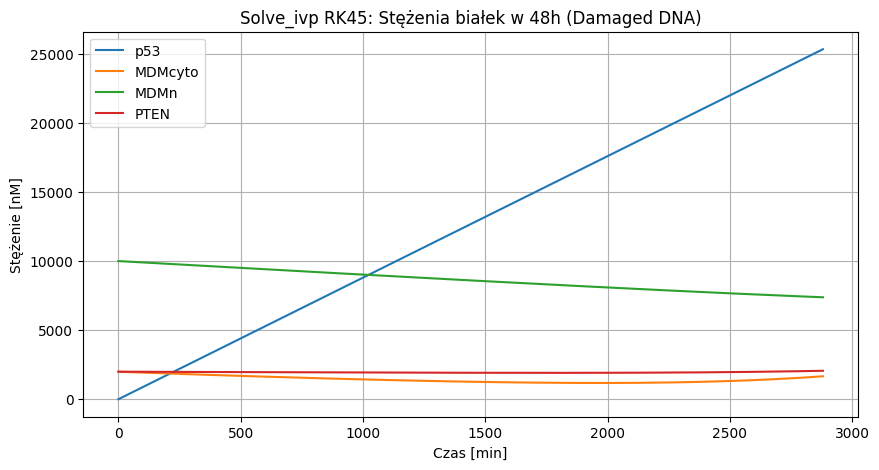

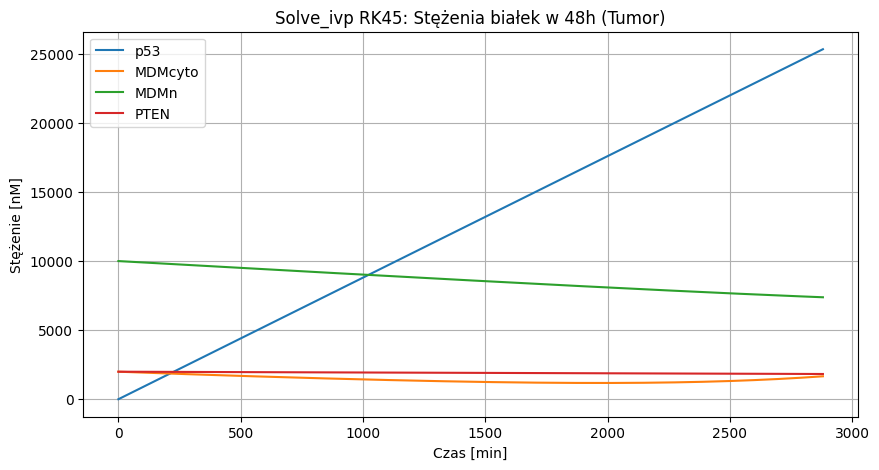

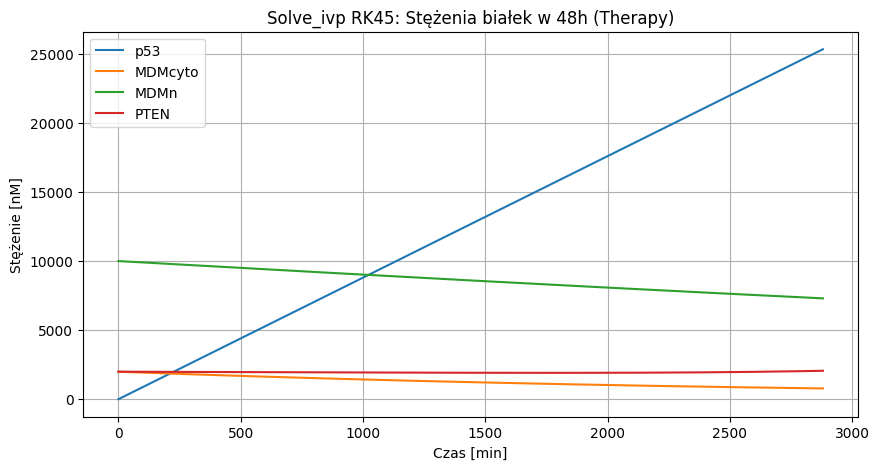

In [8]:
from scipy.integrate import solve_ivp

# Definicja układu równań różniczkowych dla solve_ivp
def model_ode(t, y, siRNA=False, pten_off=False, no_DNA_damage=False):
    p53, mdmcyto, mdmn, pten = y
    dydt = [
        f_p53(p53, mdmn),
        f_mdmcyto(p53, mdmcyto, pten, siRNA, no_DNA_damage),
        f_mdmn(mdmn, mdmcyto, pten, no_DNA_damage),
        f_pten(pten, p53, pten_off)
    ]
    return dydt

t_span = (0, 48*60)  # od 0 do 2880 minut
t_eval = np.arange(0, 48*60 + h, h)
y0 = [p53_0, mdmcyto_0, mdmn_0, pten_0]

for scenario in scenarios:
    siRNA, pten_off, no_DNA_damage = conditions[scenario]
    sol = solve_ivp(
        model_ode, t_span, y0, method='RK45', t_eval=t_eval,
        args=(siRNA, pten_off, no_DNA_damage)
    )
    plt.figure(figsize=(10,5))
    plt.plot(sol.t, sol.y[0], label="p53")
    plt.plot(sol.t, sol.y[1], label="MDMcyto")
    plt.plot(sol.t, sol.y[2], label="MDMn")
    plt.plot(sol.t, sol.y[3], label="PTEN")
    plt.xlabel("Czas [min]")
    plt.ylabel("Stężenie [nM]")
    plt.title(f"Solve_ivp RK45: Stężenia białek w 48h ({scenario})")
    plt.legend()
    plt.grid(True)
    plt.show()

## 6. Wnioski

- Krótkie podsumowanie wyników i obserwacji dla każdego scenariusza.
- Uwagi dotyczące działania algorytmu RK4 i RK45 oraz wpływu parametrów.

---

## 7. Pełny kod programu

Kod źródłowy znajduje się w komórkach powyżej.